## Import Libraries and Describing our data
Reads a CSV file `(speed_data_data.csv)` into a pandas DataFrame called `df`.  
Calls the `describe()` function on the DataFrame to display summary statistics of the dataset.  

In [67]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from typing import List, Tuple, Union

df = pd.read_csv('./data/speed_data_data.csv', engine='python', encoding='utf-8')
df.describe()

,gender,age,income,goal,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
count,8378.000000,8283.000000,4279.000000,8299.000000,8378.000000,8176.000000,8101.000000,8082.000000,8028.000000,7666.000000,7311.000000,8138.000000,8069.000000,8003.000000
mean,0.500597,26.358928,44887.606450,2.122063,0.419909,6.189995,7.175164,7.368597,6.400598,6.777524,5.474559,6.134087,5.207523,0.948769
std,0.500029,3.566763,17206.920962,1.407181,0.493573,1.950169,1.740315,1.550453,1.953702,1.794055,2.156363,1.841285,2.129565,0.989889
min,0.000000,18.000000,8607.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,24.000000,31516.000000,1.000000,0.000000,5.000000,6.000000,6.000000,5.000000,6.000000,4.000000,5.000000,4.000000,0.000000
50%,1.000000,26.000000,43185.000000,2.000000,0.000000,6.000000,7.000000,7.000000,7.000000,7.000000,6.000000,6.000000,5.000000,0.000000
75%,1.000000,28.000000,54303.000000,2.000000,1.000000,8.000000,8.000000,8.000000,8.000000,8.000000,7.000000,7.000000,7.000000,2.000000
max,1.000000,55.000000,109031.000000,6.000000,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,8.000000


Based on the provided `describe()` output of the dataset, we can observe the following:

* The count of values `varies` for each column, indicating the `presence of missing data`.  
* The `mean value` of the `gender column` is approximately `0.5006`, which suggests an `approximately equal distribution between genders` (0 representing one gender and 1 representing the other).
* The average dec value is around `0.42`, indicating that approximately `42%` of the participants got a date.

Where Ploting the result to make it easier to visualize.

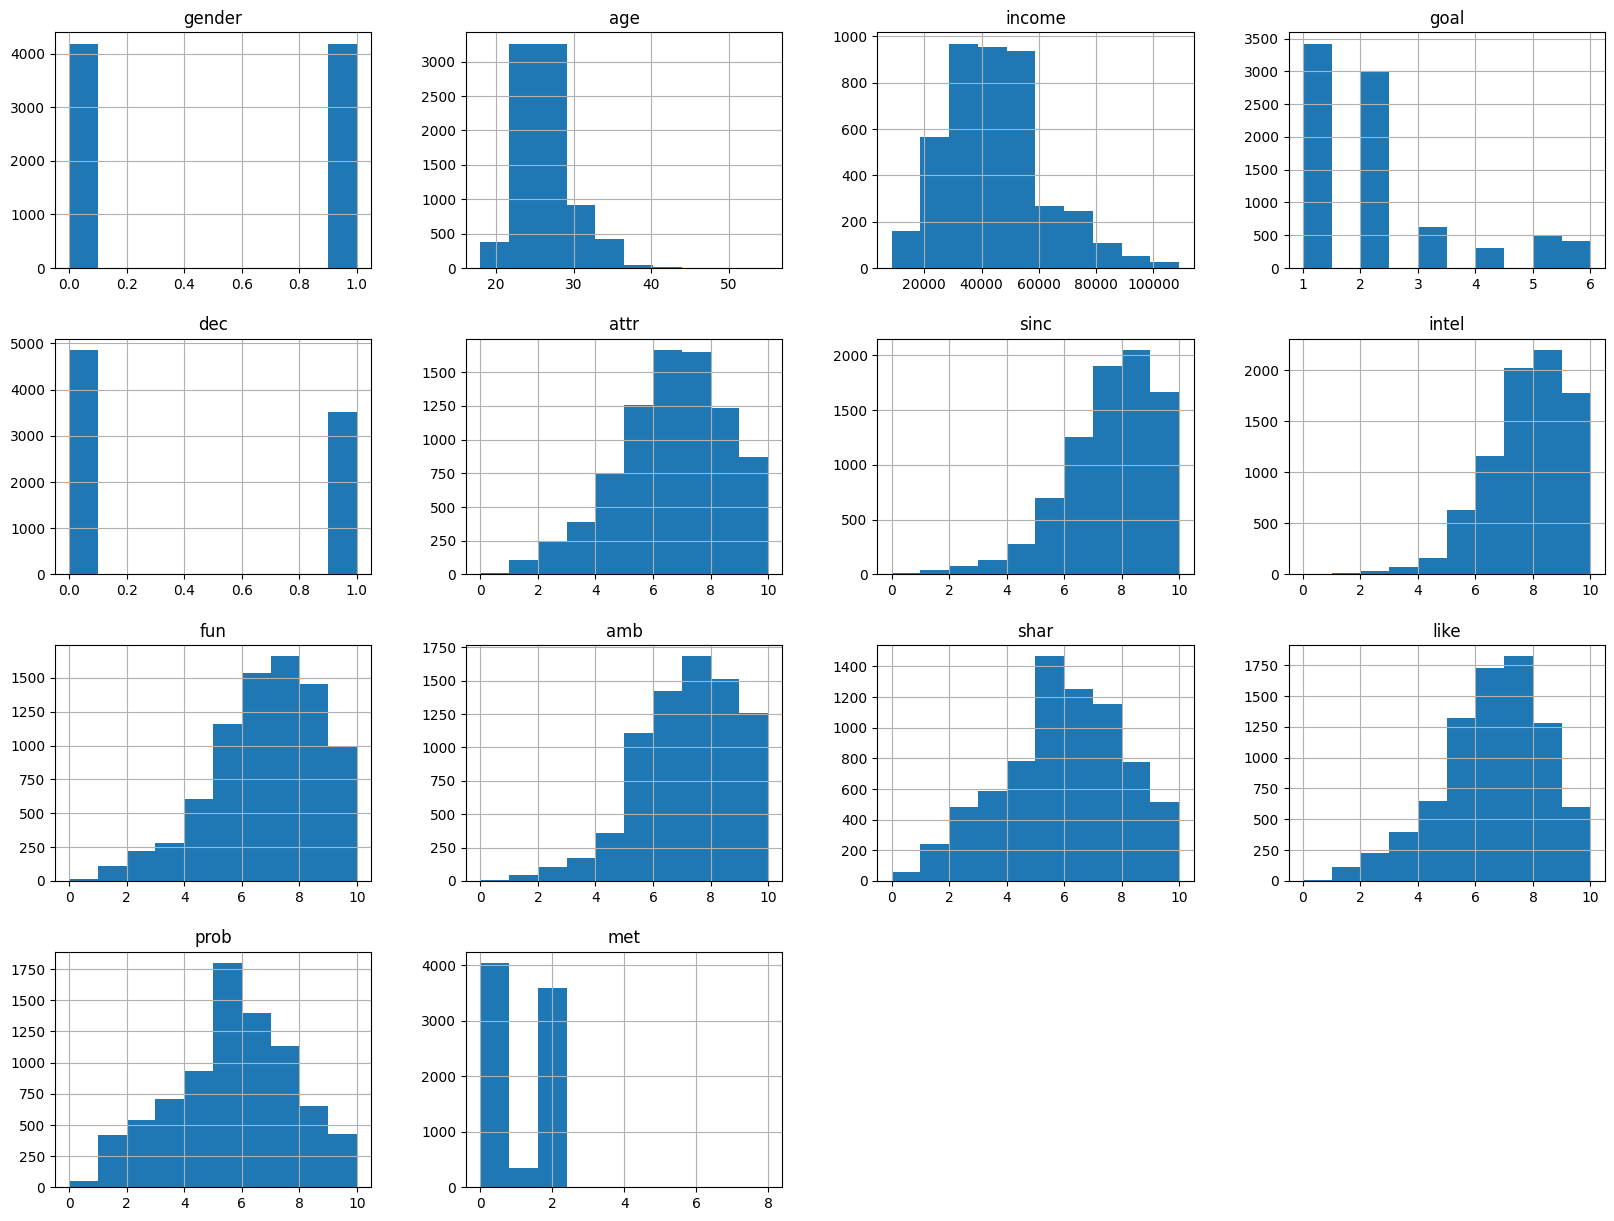

In [49]:
df.hist(figsize=(20, 15))
plt.show()

In [50]:
cp_df = df.copy()
corr = cp_df.corr()
corr.style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_28516/1199475976.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = cp_df.corr()


,gender,age,income,goal,dec,attr,sinc,intel,fun,amb,shar,like,prob,met
gender,1.000000,0.070574,0.035244,0.025949,0.110232,0.138645,0.043357,-0.050754,0.061249,-0.097410,0.030922,0.076875,-0.003813,-0.002997
age,0.070574,1.000000,-0.068260,0.089560,0.015885,0.040372,0.014232,0.016539,0.004899,-0.025247,0.021954,0.027324,-0.012817,-0.115505
income,0.035244,-0.068260,1.000000,-0.044622,0.040603,-0.003993,0.048437,-0.010438,-0.008889,-0.018103,0.026623,0.012539,0.037773,0.083963
goal,0.025949,0.089560,-0.044622,1.000000,-0.001840,0.043779,0.047276,0.062810,0.016774,0.042690,-0.002359,0.047754,-0.032688,0.052158
dec,0.110232,0.015885,0.040603,-0.001840,1.000000,0.486775,0.209994,0.217313,0.414477,0.183659,0.400644,0.513463,0.310861,0.016100
attr,0.138645,0.040372,-0.003993,0.043779,0.486775,1.000000,0.399897,0.391064,0.586382,0.359438,0.480312,0.667239,0.261051,-0.001349
sinc,0.043357,0.014232,0.048437,0.047276,0.209994,0.399897,1.000000,0.657664,0.491693,0.456529,0.398425,0.518671,0.319559,0.044370
intel,-0.050754,0.016539,-0.010438,0.062810,0.217313,0.391064,0.657664,1.000000,0.494370,0.627483,0.400285,0.509409,0.263901,0.027458
fun,0.061249,0.004899,-0.008889,0.016774,0.414477,0.586382,0.491693,0.494370,1.000000,0.489806,0.617989,0.691248,0.380460,0.026459
amb,-0.097410,-0.025247,-0.018103,0.042690,0.183659,0.359438,0.456529,0.627483,0.489806,1.000000,0.432839,0.443072,0.273590,0.065699


From the correlation matrix, we can observe the following:

- The correlation values range from -1 to 1, representing the strength and direction of the linear relationship between pairs of variables. A correlation coefficient of 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation.
- The diagonal values of the correlation matrix are all 1, which is expected since they represent the correlation of each variable with itself.
- There are some variables that show a moderate positive correlation with each other. For example, the variables `dec` (decision) and `attr` (attractiveness) have a correlation coefficient of 0.49, indicating a moderate positive relationship.
- Some variables have weak positive or negative correlations with each other. For instance, the variables `gender` and `age` have a correlation coefficient of 0.071, suggesting a weak positive relationship.
- It's worth noting that correlation does not imply causation. The correlation coefficients only capture the linear relationship between variables and do not provide information about the underlying causes or direction of the relationship.

From this correlation matrix we can see that the features `attr`, `sinc`, `fun`, `amb`, `shar`, `like`, `prob` seems to have greate impact on `dec` which is the value we will try to predict.

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def split_data(X: np.ndarray, y: np.ndarray, test_size: float = 0.2, random_state: int = 42) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Split the data into training, validation, and test sets, and convert them to PyTorch tensors.

    Args:
        X (np.ndarray): Input features.
        y (np.ndarray): Target labels.
        test_size (float, optional): The proportion of the dataset to include in the test split.
            Defaults to 0.2.
        random_state (int, optional): Controls the shuffling applied to the data before splitting.
            Defaults to 42.

    Returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
            A tuple containing the training, validation, and test sets as PyTorch tensors:
            - X_train_tensor: Training features tensor.
            - X_val_tensor: Validation features tensor.
            - X_test_tensor: Test features tensor.
            - y_train_tensor: Training labels tensor.
            - y_val_tensor: Validation labels tensor.
            - y_test_tensor: Test labels tensor.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X_train_tensor = torch.from_numpy(X_train).float().to(device)
    y_train_tensor = torch.from_numpy(y_train).float().to(device)
    X_val_tensor = torch.from_numpy(X_val).float().to(device)
    y_val_tensor = torch.from_numpy(y_val).float().to(device)
    X_test_tensor = torch.from_numpy(X_test).float().to(device)
    y_test_tensor = torch.from_numpy(y_test).float().to(device)

    return X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor

# Using result form the corelation matrix we can isolate those paramteres for training
rating_features = ['attr', 'sinc', 'fun', 'amb', 'shar', 'like', 'prob']

X = df.drop('dec', axis=1)
X_copy = X

# Data X
X = df[rating_features].values
y = df['dec'].values

imputer = SimpleImputer(strategy='most_frequent')
X = imputer.fit_transform(X)

X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor = split_data(X, y)

Device: cpu


The code snippet performs the following tasks:

1. Checks the availability of a CUDA-enabled GPU device. If a CUDA device is available, it sets the device variable to "cuda"; otherwise, it sets it to "cpu". This allows the code to utilize GPU acceleration if possible.

2. Defines a function named `split_data` that takes input features (`X`) and target variable (`y`) as NumPy arrays, along with optional parameters for test size and random state. It uses scikit-learn's `train_test_split` function to split the data into train, validation, and test sets. The train-test split is performed twice: first to split the data into train and validation sets, and then to split the train set further into train and test sets.

3. Converts the NumPy arrays into PyTorch tensors and moves them to the chosen device (GPU or CPU) using `torch.from_numpy().float().to(device)`. This ensures that the data is in the correct format and on the appropriate device for training and inference.

4. Returns the train, validation, and test data tensors (`X_train_tensor`, `X_val_tensor`, `X_test_tensor`, `y_train_tensor`, `y_val_tensor`, `y_test_tensor`) as a tuple.

The code snippet sets up the data preprocessing and splitting steps necessary before training a PyTorch model. It also ensures that the data is properly formatted and ready to be fed into a model for training and evaluation.

# Setting Up for Training
---

In [52]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

def grid_search(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                learning_rates: List[float], num_epochs_list: List[int]) -> Tuple[float, int]:
    """
    Perform a grid search to find the best combination of learning rate and number of epochs.

    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        X_val (np.ndarray): Validation features.
        y_val (np.ndarray): Validation labels.
        learning_rates (List[float]): List of learning rates to try.
        num_epochs_list (List[int]): List of numbers of epochs to try.

    Returns:
        Tuple[float, int]: A tuple containing the best learning rate, best number of epochs, and the best accuracy score.
    """

    best_learning_rate = None
    best_num_epochs = None
    best_accuracy = 0.0

    for learning_rate in learning_rates:
        for num_epochs in num_epochs_list:
            # Create the model
            model = LogisticRegression(input_size=X_train.shape[1]).to(device)

            # Define the loss function and optimizer
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

            # Train the model
            _, _, train_accuracy_scores, val_accuracy_scores = train_model(model, criterion, optimizer,
                                                                           num_epochs, X_train, y_train, X_val, y_val)

            # Get the accuracy score from the validation set
            accuracy = val_accuracy_scores[-1]

            # Track the best learning rate and number of epochs
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_learning_rate = learning_rate
                best_num_epochs = num_epochs

            print(f"Learning Rate: {learning_rate:.4f}, Number of Epochs: {num_epochs}, Validation Accuracy: {accuracy:.2%}")

    return best_learning_rate, best_num_epochs

def grid_search_epochs(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                       num_epochs_list: List[int], learning_rate: float) -> int:
    """
    Perform a grid search to find the best number of epochs for a given learning rate.

    Args:
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training labels.
        X_val (np.ndarray): Validation features.
        y_val (np.ndarray): Validation labels.
        num_epochs_list (List[int]): List of numbers of epochs to try.
        learning_rate (float): Learning rate to use.

    Returns:
        int: The best number of epochs based on validation performance.
    """

    best_num_epochs = None
    best_accuracy = 0.0

    for num_epochs in num_epochs_list:
        # Create the model
        model = LogisticRegression(input_size=X_train.shape[1]).to(device)

        # Define the loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        _, _, train_accuracy_scores, val_accuracy_scores = train_model(model, criterion, optimizer,
                                                                       num_epochs, X_train, y_train, X_val, y_val)

        # Get the accuracy score from the validation set
        accuracy = val_accuracy_scores[-1]

        # Track the best number of epochs
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_num_epochs = num_epochs

        print(f"Number of Epochs: {num_epochs}, Validation Accuracy: {accuracy:.2%}")

    return best_num_epochs

def plot_training_stats(num_epochs: int, train_accuracy_scores: List[float], val_accuracy_scores: List[float],
                        train_losses: List[float], val_losses: List[float], lr: float) -> None:
    """
    Plot the training statistics including accuracy and loss curves.

    Args:
        num_epochs (int): Number of epochs.
        train_accuracy_scores (List[float]): List of training accuracy scores.
        val_accuracy_scores (List[float]): List of validation accuracy scores.
        train_losses (List[float]): List of training loss values.
        val_losses (List[float]): List of validation loss values.
        lr (float): Learning rate.

    Returns:
        None
    """

    # Plot accuracy scores
    plt.plot(range(1, num_epochs + 1), train_accuracy_scores, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracy_scores, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy Score')
    plt.title(f'Training and Validation Accuracy with model (lr={lr} and epochs={num_epochs})')
    plt.legend()
    plt.show()

    # Plot losses
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss with model (lr={lr} and epochs={num_epochs})')
    plt.legend()
    plt.show()

def grid_search_learning_rate(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray,
                              learning_rates: List[float]) -> float:
    """
    Perform grid search to find the best learning rate.

    Args:
        X_train (np.ndarray): Training data inputs.
        y_train (np.ndarray): Training data labels.
        X_val (np.ndarray): Validation data inputs.
        y_val (np.ndarray): Validation data labels.
        learning_rates (List[float]): List of learning rates to try.

    Returns:
        float: Best learning rate.
    """

    best_learning_rate = None
    best_accuracy = 0.0

    for learning_rate in learning_rates:
        # Create the model
        model = LogisticRegression(input_size=X_train.shape[1]).to(device)

        # Define the loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model
        _, _, train_accuracy_scores, val_accuracy_scores = train_model(model, criterion, optimizer,
                                                                       num_epochs, X_train, y_train, X_val, y_val)

        # Get the accuracy score from the validation set
        accuracy = val_accuracy_scores[-1]

        # Track the best learning rate
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_learning_rate = learning_rate

        print(f"Learning Rate: {learning_rate:.4f}, Validation Accuracy: {accuracy:.2%}")

    return best_learning_rate

def train_model(model: nn.Module, criterion: nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int,
                X_train: torch.Tensor, y_train: torch.Tensor, X_val: torch.Tensor, y_val: torch.Tensor) -> Tuple[List[float], List[float], List[float], List[float]]:
    """
    Train the model and track training statistics.

    Args:
        model (nn.Module): Model to be trained.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        num_epochs (int): Number of training epochs.
        X_train (torch.Tensor): Training data inputs.
        y_train (torch.Tensor): Training data labels.
        X_val (torch.Tensor): Validation data inputs.
        y_val (torch.Tensor): Validation data labels.

    Returns:
        Tuple[List[float], List[float], List[float], List[float]]: Training and validation statistics.
            - train_losses: List of training losses at each epoch.
            - val_losses: List of validation losses at each epoch.
            - train_accuracy_scores: List of training accuracy scores at each epoch.
            - val_accuracy_scores: List of validation accuracy scores at each epoch.
    """

    train_losses = []
    val_losses = []
    train_accuracy_scores = []
    val_accuracy_scores = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(X_train.float())
        loss = criterion(outputs, y_train.unsqueeze(1))
        train_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_pred = np.round(outputs.detach().cpu().numpy())
        train_target = np.round(y_train.detach().cpu().numpy())
        train_accuracy = accuracy_score(train_target, train_pred)
        train_accuracy_scores.append(train_accuracy)

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val.float())
            val_loss = criterion(val_outputs, y_val.unsqueeze(1))
            val_losses.append(val_loss.item())

            val_pred = np.round(val_outputs.detach().cpu().numpy())
            val_target = np.round(y_val.detach().cpu().numpy())
            val_accuracy = accuracy_score(val_target, val_pred)
            val_accuracy_scores.append(val_accuracy)

        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    return train_losses, val_losses, train_accuracy_scores, val_accuracy_scores

def evaluate_model(model: nn.Module, X_test: torch.Tensor, y_test: torch.Tensor) -> np.ndarray:
    """
    Evaluate the trained model on the test set.

    Args:
        model (nn.Module): Trained model.
        X_test (torch.Tensor): Test set inputs.
        y_test (torch.Tensor): Test set labels.

    Returns:
        np.ndarray: Predicted values from the model.
    """

    with torch.no_grad():
        predicted = model(X_test).detach().cpu().numpy()

    return predicted


The code provided implements several functions for training, evaluating, and conducting a grid search for a logistic regression model implemented using PyTorch.

Here's a brief explanation of each function:

- LogisticRegression: This class represents the logistic regression model. It takes the input size as a parameter and defines the linear layer and sigmoid activation function used in the forward pass.

- grid_search: This function performs a grid search over different learning rates and number of epochs to find the best combination that yields the highest validation accuracy. It initializes a logistic regression model, defines the loss function and optimizer, and trains the model using the train_model function. It tracks the best learning rate, number of epochs, and validation accuracy throughout the grid search.

- grid_search_epochs: This function performs a grid search over different numbers of epochs, keeping the learning rate constant. It follows a similar process as grid_search but focuses only on the number of epochs.

- plot_training_stats: This function plots the training and validation accuracy scores, as well as the training and validation losses, over the epochs. It takes the number of epochs, accuracy scores, loss values, and learning rate as parameters.

- grid_search_learning_rate: This function performs a grid search over different learning rates, keeping the number of epochs constant. It follows a similar process as grid_search but focuses only on the learning rate.

- train_model: This function trains the logistic regression model. It takes the model, loss criterion, optimizer, number of epochs, training data, and validation data as parameters. It iterates over the specified number of epochs, performs forward and backward passes, calculates the training and validation losses, and tracks the accuracy scores. It returns the training and validation losses, as well as the training and validation accuracy scores.

- evaluate_model: This function evaluates the trained model on the test data. It takes the model, test data, and corresponding labels as parameters. It performs forward pass on the test data, obtains the predicted probabilities, and returns the predicted values.

The code snippet provides a set of functions that can be used for training, evaluating, and tuning a logistic regression model in PyTorch.

Learning Rate: 0.0010, Number of Epochs: 10, Validation Accuracy: 42.21%
Learning Rate: 0.0010, Number of Epochs: 20, Validation Accuracy: 56.15%
Learning Rate: 0.0010, Number of Epochs: 50, Validation Accuracy: 45.04%
Epoch [100/100], Train Loss: 0.6450, Val Loss: 0.6528
Learning Rate: 0.0010, Number of Epochs: 100, Validation Accuracy: 59.43%
Epoch [100/200], Train Loss: 0.8113, Val Loss: 0.8049
Epoch [200/200], Train Loss: 0.7109, Val Loss: 0.7072
Learning Rate: 0.0010, Number of Epochs: 200, Validation Accuracy: 53.99%
Epoch [100/500], Train Loss: 0.7475, Val Loss: 0.7374
Epoch [200/500], Train Loss: 0.6598, Val Loss: 0.6617
Epoch [300/500], Train Loss: 0.6541, Val Loss: 0.6561
Epoch [400/500], Train Loss: 0.6477, Val Loss: 0.6499
Epoch [500/500], Train Loss: 0.6408, Val Loss: 0.6433
Learning Rate: 0.0010, Number of Epochs: 500, Validation Accuracy: 61.52%
Epoch [100/1000], Train Loss: 0.7745, Val Loss: 0.7833
Epoch [200/1000], Train Loss: 0.7501, Val Loss: 0.7581
Epoch [300/1000],

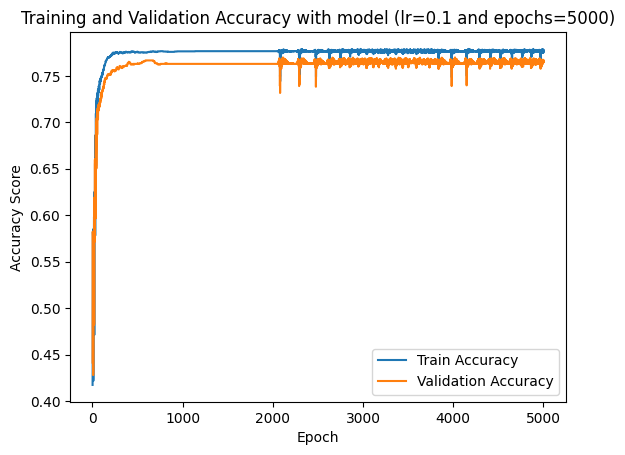

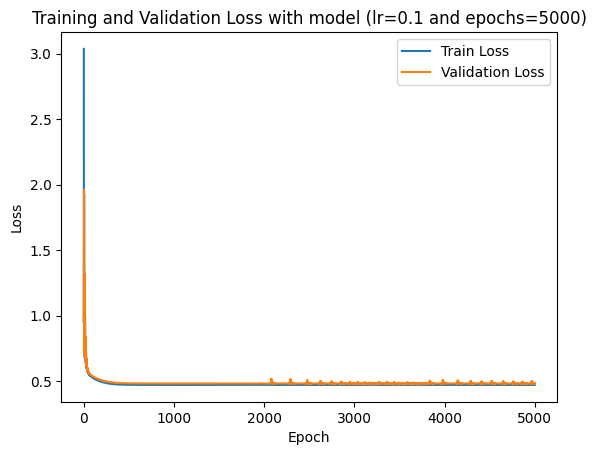

In [71]:

learning_rates = [0.001, 0.01, 0.1]
num_epochs_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
best_learning_rate, best_num_epochs = grid_search(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor,
                                                  learning_rates, num_epochs_list)

model = LogisticRegression(input_size=X.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

print("Best Learning Rate:", best_learning_rate)
print("Best Number of Epochs:", best_num_epochs)

train_losses, val_losses, train_accuracy_scores, val_accuracy_scores = train_model(model, criterion, optimizer, best_num_epochs, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
plot_training_stats(best_num_epochs, train_accuracy_scores, val_accuracy_scores, train_losses, val_losses, best_learning_rate)

# Step 4: Evaluate the model
predicted_train = evaluate_model(model, X_train_tensor, y_train_tensor)
predicted_test = evaluate_model(model, X_test_tensor, y_test_tensor)

The provided code snippet performs the following steps:

1. It defines a list of learning rates `[0.001, 0.01, 0.1]` and a list of number of epochs `[10, 20, 50, 100, 200, 500, 1000, 2000, 5000]`.

2. It calls the `grid_search` function with the training and validation data, learning rates, and number of epochs. This function performs a grid search to find the best learning rate and number of epochs based on the highest validation accuracy. The best learning rate and number of epochs are stored in the variables `best_learning_rate` and `best_num_epochs`, respectively.

3. It creates a new instance of the logistic regression model with the best learning rate and input size. It also defines the loss criterion and optimizer using the Adam optimizer with the best learning rate.

4. It prints the best learning rate and best number of epochs found during the grid search.

5. It calls the `train_model` function to train the model with the best number of epochs. It passes the model, loss criterion, optimizer, best number of epochs, and the training and validation data. This function returns the training and validation losses, as well as the training and validation accuracy scores.

6. It calls the `plot_training_stats` function to plot the training and validation accuracy scores and losses over the epochs. It passes the best number of epochs, training and validation accuracy scores, training and validation losses, and the best learning rate.

7. It calls the `evaluate_model` function to evaluate the trained model on the training and test data. It passes the model and the respective data tensors. This function returns the predicted values for the training and test data.

The grid search is used to tune the hyperparameters of the logistic regression model. By performing a grid search, we iterate over different combinations of hyperparameters to find the best values that result in the highest validation accuracy. In this case, the grid search is performed on the learning rate and number of epochs.

Accuracy: 75.60%
Precision: 73.96%
Recall: 66.67%
F1 Score: 70.12%
ROC AUC: 83.31%
Confusion Matrix:
[[787 169]
 [240 480]]


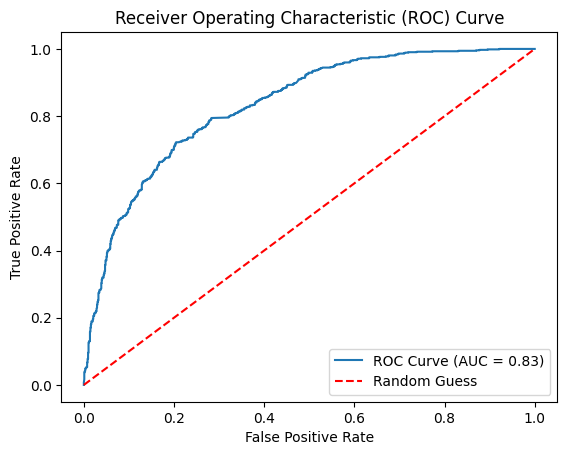

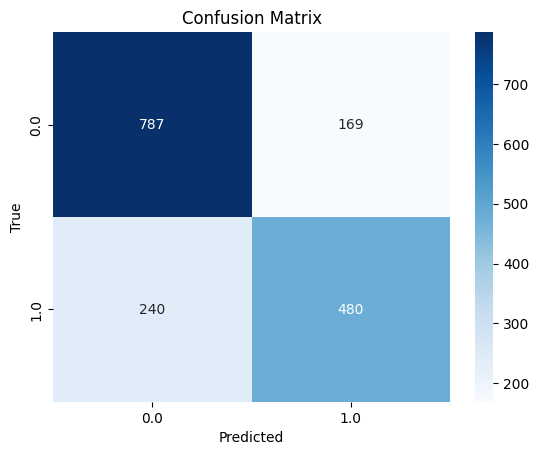

In [72]:
def evaluate_classification_performance(y_true: Union[np.ndarray, list], y_pred: Union[np.ndarray, list]) -> None:
    """
    Evaluate the classification performance based on the predicted and true labels.

    Args:
        y_true (Union[np.ndarray, list]): True labels.
        y_pred (Union[np.ndarray, list]): Predicted labels.
    """

    y_pred_rounded = np.round(y_pred)

    accuracy = accuracy_score(y_true, y_pred_rounded)
    precision = precision_score(y_true, y_pred_rounded)
    recall = recall_score(y_true, y_pred_rounded)
    f1 = f1_score(y_true, y_pred_rounded)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred_rounded)

    print("Accuracy: {:.2%}".format(accuracy))
    print("Precision: {:.2%}".format(precision))
    print("Recall: {:.2%}".format(recall))
    print("F1 Score: {:.2%}".format(f1))
    print("ROC AUC: {:.2%}".format(roc_auc))
    print("Confusion Matrix:")
    print(cm)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Plot confusion matrix
    labels = np.unique(y_true)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

y_true = y_test_tensor.cpu().numpy()
y_pred = predicted_test

evaluate_classification_performance(y_true, y_pred)

The code you provided defines a function evaluate_classification_performance that takes the true labels (y_true) and predicted labels (y_pred) as input and evaluates the classification performance of the model. Here's a breakdown of what the function does:

1. It rounds the predicted labels (y_pred) using np.round to convert them into binary values (0 or 1) since the logistic regression model predicts probabilities.

2. It calculates various classification metrics such as `accuracy, precision, recall, F1 score, ROC curve, ROC AUC, and the confusion matrix` using functions from `scikit-learn` (`accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix`).

3. It prints the computed metrics, including `accuracy, precision, recall, F1 score, ROC AUC, and the confusion matrix`.

4. It plots the `ROC curve` using `plt.plot`.

5. It plots the `confusion matrix` using `sns.heatmap`.

Finally, the function is called with the `true labels (y_true)` and `predicted labels (y_pred)` obtained from the evaluation of the logistic regression model on the test set.

This function provides a comprehensive analysis of the model's classification performance, allowing you to assess its accuracy, precision, recall, F1 score, and visualize the ROC curve and confusion matrix.

# Going a bit further
---

In [66]:
def create_ratings_pipeline() -> make_pipeline:
    """
    Create a pipeline for preprocessing rating features.

    Returns:
        make_pipeline: Rating feature preprocessing pipeline.
    """
    return make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        StandardScaler()
    )

def create_demographics_num_pipeline() -> make_pipeline:
    """
    Create a pipeline for preprocessing numeric demographic features.

    Returns:
        make_pipeline: Numeric demographic feature preprocessing pipeline.
    """
    return make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler()
    )

def create_demographics_cat_pipeline() -> make_pipeline:
    """
    Create a pipeline for preprocessing categorical demographic features.

    Returns:
        make_pipeline: Categorical demographic feature preprocessing pipeline.
    """
    return make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder()
    )

def create_full_cleanup_pipeline(rating_features: List[str], demographic_num_features: List[str], demographic_cat_features: List[str]) -> ColumnTransformer:
    """
    Create a full cleanup pipeline for preprocessing all features.

    Args:
        rating_features (List[str]): List of rating features.
        demographic_num_features (List[str]): List of numeric demographic features.
        demographic_cat_features (List[str]): List of categorical demographic features.

    Returns:
        ColumnTransformer: Full cleanup feature preprocessing pipeline.
    """
    pipelines = [
        ('ratings', create_ratings_pipeline(), rating_features),
        ('demo_num', create_demographics_num_pipeline(), demographic_num_features),
        ('demo_cat', create_demographics_cat_pipeline(), demographic_cat_features)
    ]
    return ColumnTransformer(pipelines)

# Example usage:
rating_features = ['attr', 'sinc', 'fun', 'amb', 'shar', 'like', 'prob']
demographic_num_features = ['age', 'income']
demographics_cat_features = ['gender', 'career', 'goal', 'met']

X_df = pd.DataFrame(X_copy, columns=rating_features + demographic_num_features + demographics_cat_features)

full_cleanup_pipeline = create_full_cleanup_pipeline(rating_features, demographic_num_features, demographics_cat_features)

X_transformed = full_cleanup_pipeline.fit_transform(X_df)
X_transformed = X_transformed.toarray()

X_train_tensor, X_val_tensor, X_test_tensor, y_train_tensor, y_val_tensor, y_test_tensor = split_data(X_transformed, y)

The code provided defines several utility functions to create pipelines for data preprocessing and transformation. These pipelines are useful for handling different types of features in the dataset before feeding them into a machine learning model.

Here are the functions and their purposes:

- `create_ratings_pipeline`: This function creates a pipeline for rating features. It uses `SimpleImputer` with the strategy set to 'most_frequent' to fill any missing values with the most frequent value in the column. It then applies `StandardScaler` to standardize the feature values.

- `create_demographics_num_pipeline`: This function creates a pipeline for numerical demographic features. It uses `SimpleImputer` with the strategy set to 'mean' to fill any missing values with the mean of the column. It then applies `StandardScaler` to standardize the feature values.

- `create_demographics_cat_pipeline`: This function creates a pipeline for categorical demographic features. It uses `SimpleImputer` with the strategy set to 'most_frequent' to fill any missing values with the most frequent value in the column. It then applies `OneHotEncoder` to convert the categorical features into a one-hot encoded representation.

- `create_full_cleanup_pipeline`: This function creates a full cleanup pipeline that combines the above pipelines for rating, numerical demographic, and categorical demographic features. It takes lists of feature names as input and associates each feature list with the corresponding pipeline. It returns a `ColumnTransformer` object that applies the specified pipelines to the corresponding features.

---

- `rating_features`, `demographic_num_features`, and `demographic_cat_features` are lists of feature names corresponding to rating, numerical demographic, and categorical demographic features, respectively.

- `X_df` is a pandas DataFrame that contains the input data with columns named according to the feature names.

- `full_cleanup_pipeline` is created using `create_full_cleanup_pipeline` function by passing the feature lists.

- `X_transformed` is obtained by applying the `full_cleanup_pipeline` to `X_df`. This transforms the input data by applying the appropriate preprocessing steps to each feature.

- Finally, the transformed data is split into training, validation, and test sets using the `split_data` function.

By using these pipelines, you can conveniently handle missing values, standardize numerical features, and encode categorical features in a structured and consistent manner, preparing the data for, hopefully, training a machine learning model.

Epoch [100/5000], Train Loss: 0.5730, Val Loss: 0.5703
Epoch [200/5000], Train Loss: 0.5246, Val Loss: 0.5243
Epoch [300/5000], Train Loss: 0.4932, Val Loss: 0.4970
Epoch [400/5000], Train Loss: 0.4700, Val Loss: 0.4783
Epoch [500/5000], Train Loss: 0.4521, Val Loss: 0.4647
Epoch [600/5000], Train Loss: 0.4378, Val Loss: 0.4544
Epoch [700/5000], Train Loss: 0.4262, Val Loss: 0.4463
Epoch [800/5000], Train Loss: 0.4165, Val Loss: 0.4400
Epoch [900/5000], Train Loss: 0.4083, Val Loss: 0.4348
Epoch [1000/5000], Train Loss: 0.4012, Val Loss: 0.4305
Epoch [1100/5000], Train Loss: 0.3951, Val Loss: 0.4269
Epoch [1200/5000], Train Loss: 0.3897, Val Loss: 0.4239
Epoch [1300/5000], Train Loss: 0.3849, Val Loss: 0.4213
Epoch [1400/5000], Train Loss: 0.3807, Val Loss: 0.4191
Epoch [1500/5000], Train Loss: 0.3769, Val Loss: 0.4172
Epoch [1600/5000], Train Loss: 0.3735, Val Loss: 0.4155
Epoch [1700/5000], Train Loss: 0.3704, Val Loss: 0.4140
Epoch [1800/5000], Train Loss: 0.3676, Val Loss: 0.4128
E

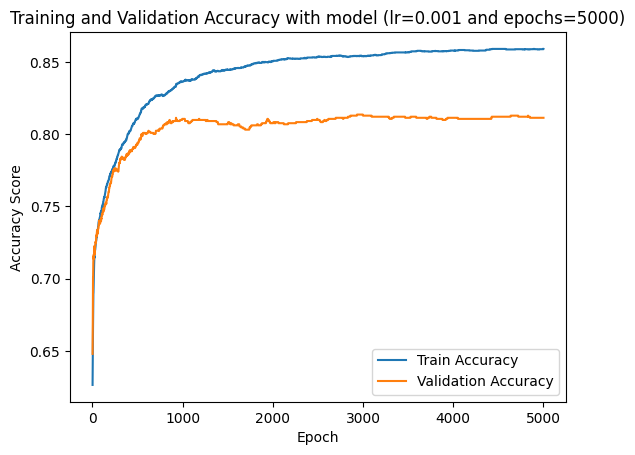

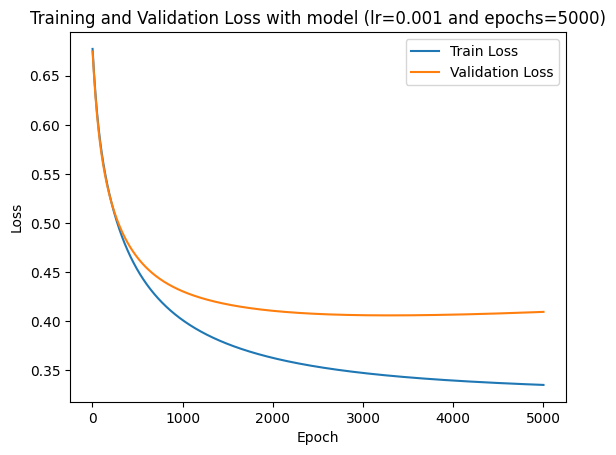

In [68]:
model = LogisticRegression(input_size=X_transformed.shape[1]).to(device)

# Step 2: Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

# Step 3: Train the model
# num_epochs = len(X_train)
train_losses, val_losses, train_accuracy_scores, val_accuracy_scores = train_model(model, criterion, optimizer, best_num_epochs, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
plot_training_stats(best_num_epochs, train_accuracy_scores, val_accuracy_scores, train_losses, val_losses, best_learning_rate)

# Step 4: Evaluate the model
predicted_train = evaluate_model(model, X_train_tensor, y_train_tensor)
predicted_test = evaluate_model(model, X_test_tensor, y_test_tensor)

Accuracy: 80.19%
Precision: 78.12%
Recall: 74.86%
F1 Score: 76.45%
ROC AUC: 88.07%
Confusion Matrix:
[[805 151]
 [181 539]]


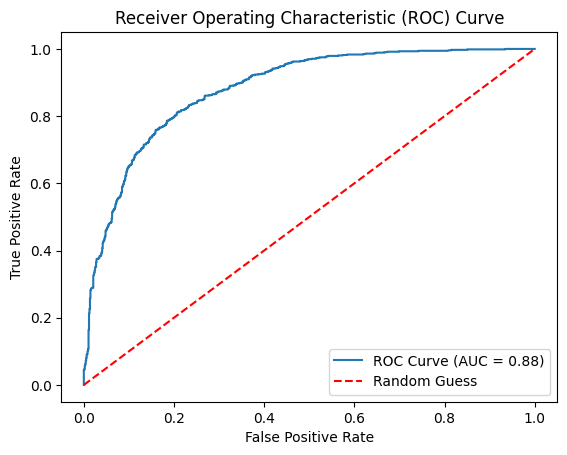

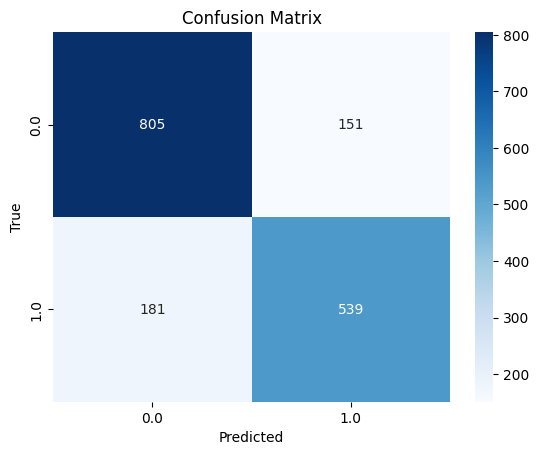

In [57]:
y_true = y_test_tensor.cpu().numpy()
y_pred = predicted_test

evaluate_classification_performance(y_true, y_pred)

By using the data preprocessing pipelines, we were able to handle the data more gracefully and improve your model's performance.

By gracefully handling the data using these preprocessing pipelines, we were able to enhance the model's ability to learn and make accurate predictions, resulting in improved performance and more reliable insights from the evaluation metrics.

Learning Rate: 0.0010, Number of Epochs: 10, Validation Accuracy: 54.14%
Learning Rate: 0.0010, Number of Epochs: 20, Validation Accuracy: 65.92%
Learning Rate: 0.0010, Number of Epochs: 50, Validation Accuracy: 70.25%
Epoch [100/100], Train Loss: 0.5819, Val Loss: 0.5801
Learning Rate: 0.0010, Number of Epochs: 100, Validation Accuracy: 74.65%
Epoch [100/200], Train Loss: 0.5717, Val Loss: 0.5703
Epoch [200/200], Train Loss: 0.5224, Val Loss: 0.5232
Learning Rate: 0.0010, Number of Epochs: 200, Validation Accuracy: 76.58%
Epoch [100/500], Train Loss: 0.5907, Val Loss: 0.5907
Epoch [200/500], Train Loss: 0.5341, Val Loss: 0.5354
Epoch [300/500], Train Loss: 0.5004, Val Loss: 0.5046
Epoch [400/500], Train Loss: 0.4763, Val Loss: 0.4842
Epoch [500/500], Train Loss: 0.4576, Val Loss: 0.4693
Learning Rate: 0.0010, Number of Epochs: 500, Validation Accuracy: 79.05%
Epoch [100/1000], Train Loss: 0.5746, Val Loss: 0.5720
Epoch [200/1000], Train Loss: 0.5259, Val Loss: 0.5258
Epoch [300/1000],

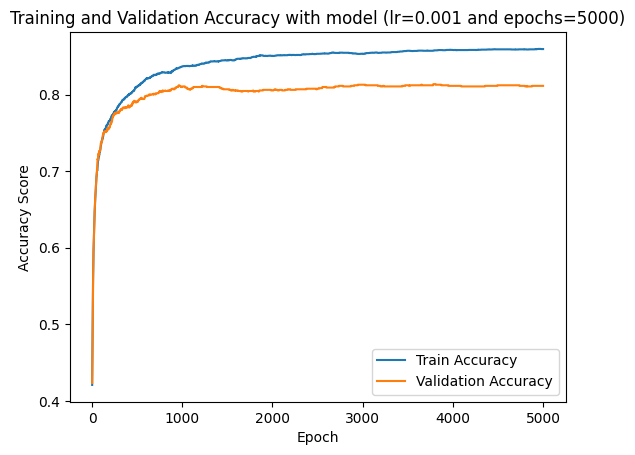

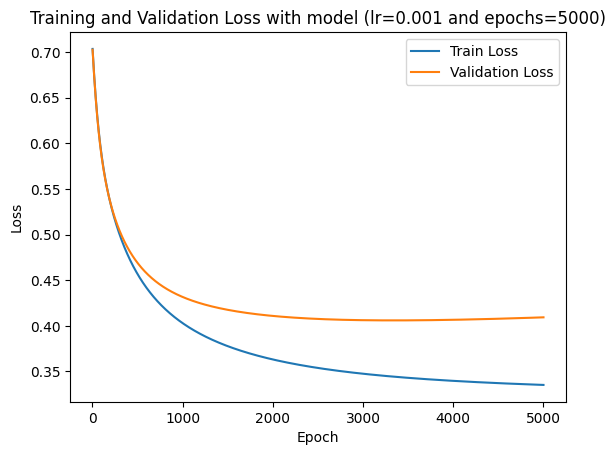

In [58]:
# Define the learning rate search space
learning_rates = [0.001, 0.01, 0.1]
num_epochs_list = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
# Perform grid search for learning rate and number of epochs optimization
best_learning_rate, best_num_epochs = grid_search(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, learning_rates, num_epochs_list)

print(f"Best Learning Rate: {best_learning_rate:.4f}")
# Step 1: Create the model
model = LogisticRegression(input_size=X_transformed.shape[1]).to(device)

# Step 2: Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

# Step 3: Train the model
# num_epochs = len(X_train)
train_losses, val_losses, train_accuracy_scores, val_accuracy_scores = train_model(model, criterion, optimizer, best_num_epochs, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)
plot_training_stats(best_num_epochs, train_accuracy_scores, val_accuracy_scores, train_losses, val_losses, best_learning_rate)

# Step 4: Evaluate the model
predicted_train = evaluate_model(model, X_train_tensor, y_train_tensor)
predicted_test = evaluate_model(model, X_test_tensor, y_test_tensor)


In an effort to improve the performance of our model, we focused on optimizing the hyperparameters.  
By adjusting these parameters, we aimed to fine-tune the model's behavior and achieve better results.

Accuracy: 80.13%
Precision: 77.84%
Recall: 75.14%
F1 Score: 76.47%
ROC AUC: 88.12%
Confusion Matrix:
[[802 154]
 [179 541]]


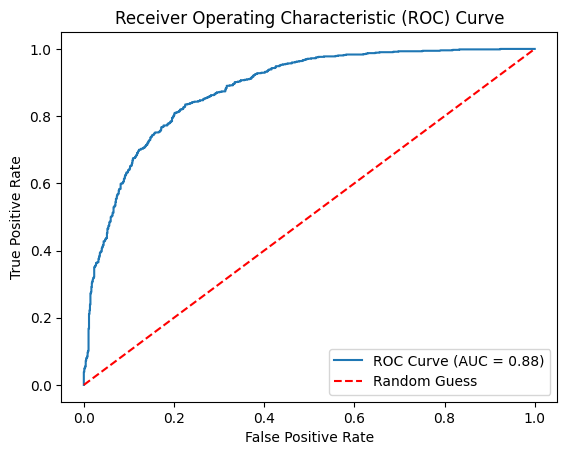

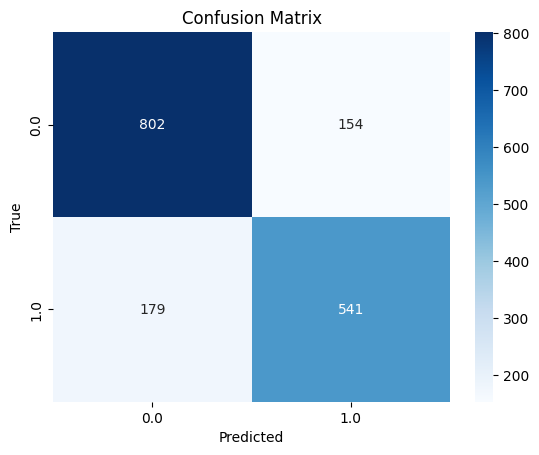

In [59]:
y_true = y_test_tensor.cpu().numpy()
y_pred = predicted_test

evaluate_classification_performance(y_true, y_pred)

Although we made efforts to tweak the hyperparameters in order to enhance the model's performance, the results did not show significant improvements. Despite exploring different combinations of learning rates and number of epochs through grid search, the overall impact on the model's performance was limited.